In [1]:
import geopy.distance
import matplotlib.pyplot as plt
import multiprocessing
import numpy as np 
import pandas as pd
import time

NYRA_START_TABLE_COLS = [
    'track_id', 
    'race_date', 
    'race_number', 
    'program_number', 
    'weight_carried', 
    'jockey', 
    'odds', 
    'position_at_finish'
]

In [2]:
results_df = pd.read_csv('./data/nyra_start_table.csv', names=NYRA_START_TABLE_COLS)

results_df['race_date'] = pd.to_datetime(results_df['race_date'])
results_df['race_date'] = results_df['race_date'].dt.date
results_df['program_number'] = results_df['program_number'].apply(lambda x: x.strip()).astype(str)

len(results_df)

14915

In [3]:
results_df.head(5).T

,0,1,2,3,4
track_id,AQU,AQU,AQU,AQU,AQU
race_date,2019-01-01,2019-01-01,2019-01-01,2019-01-01,2019-01-01
race_number,1,1,1,1,1
program_number,1,2,3,4,5
weight_carried,123,120,118,123,118
jockey,Dylan Davis,Junior Alvarado,Jose Lezcano,Jomar Garcia,Manuel Franco
odds,130,295,180,1280,1150
position_at_finish,2,3,4,5,1


In [4]:
results_df['track_id'].value_counts()

AQU    6191
BEL    5539
SAR    3185
Name: track_id, dtype: int64

In [5]:
min(results_df['race_date'])

datetime.date(2019, 1, 1)

In [6]:
max(results_df['race_date'])

datetime.date(2019, 12, 31)

In [7]:
results_df.describe()

,race_number,weight_carried,odds,position_at_finish
count,14915.000000,14915.000000,14915.000000,14915.000000
mean,5.494200,120.454040,1483.496480,4.486088
std,2.826058,3.522007,1956.137156,2.569144
min,1.000000,110.000000,0.000000,1.000000
25%,3.000000,118.000000,335.000000,2.000000
50%,6.000000,120.000000,730.000000,4.000000
75%,8.000000,122.000000,1740.000000,6.000000
max,13.000000,160.000000,19100.000000,14.000000


In [8]:
conditions_df = pd.read_csv('./data/nyra_race_table.csv')

conditions_df['race_date'] = pd.to_datetime(conditions_df['race_date'])
conditions_df['race_date'] = conditions_df['race_date'].dt.date

len(conditions_df)

2000

In [9]:
conditions_df.head(5).T

,0,1,2,3,4
track_id,AQU,AQU,AQU,AQU,AQU
race_date,2019-01-01,2019-01-01,2019-01-01,2019-01-01,2019-01-01
race_number,1,2,3,4,5
distance_id,650,600,550,900,700
course_type,D,D,D,D,D
track_condition,MY,MY,MY,MY,MY
run_up_distance,36,48,54,101,60
race_type,AOC,MCL,MCL,AOC,ALW
purse,80000,41000,35000,80000,64000
post_time,1220,1250,121,150,220


In [10]:
tracking_df = pd.read_csv('./data/nyra_tracking_table.csv')

tracking_df['race_date'] = pd.to_datetime(tracking_df['race_date'])
tracking_df['race_date'] = tracking_df['race_date'].dt.date
tracking_df['program_number'] = tracking_df['program_number'].apply(lambda x: x.strip()).astype(str)

len(tracking_df)

5228430

In [11]:
tracking_df.head(5).T

,0,1,2,3,4
track_id,AQU,AQU,AQU,AQU,AQU
race_date,2019-01-01,2019-01-01,2019-01-01,2019-01-01,2019-01-01
race_number,9,9,9,9,9
program_number,6,6,6,6,6
trakus_index,72,73,74,63,64
latitude,40.672902,40.672946,40.67299,40.67251,40.672553
longitude,-73.827607,-73.827587,-73.827568,-73.827781,-73.827762


Let's take a closer look at the lat/long data.

In [12]:
horse1_df = tracking_df[
    (tracking_df['track_id'] == 'AQU') &
    (tracking_df['race_date'] == pd.Timestamp('2019-01-01')) &
    (tracking_df['race_number'] == 9) &
    (tracking_df['program_number'] == '1')
].sort_values('trakus_index', ascending=True)

horse1_df

,track_id,race_date,race_number,program_number,trakus_index,latitude,longitude
1041293,AQU,2019-01-01,9,1,1,40.670236,-73.828819
1041294,AQU,2019-01-01,9,1,2,40.670239,-73.828818
1041283,AQU,2019-01-01,9,1,3,40.670243,-73.828816
1041284,AQU,2019-01-01,9,1,4,40.670251,-73.828812
1041285,AQU,2019-01-01,9,1,5,40.670261,-73.828808
...,...,...,...,...,...,...,...
1041300,AQU,2019-01-01,9,1,293,40.671132,-73.832142
1041289,AQU,2019-01-01,9,1,294,40.671104,-73.832155
1041290,AQU,2019-01-01,9,1,295,40.671077,-73.832168
1041291,AQU,2019-01-01,9,1,296,40.671047,-73.832181


In [13]:
horse2_df = tracking_df[
    (tracking_df['track_id'] == 'AQU') &
    (tracking_df['race_date'] == pd.Timestamp('2019-01-01')) &
    (tracking_df['race_number'] == 9) &
    (tracking_df['program_number'] == '3')
].sort_values('trakus_index', ascending=True)

horse2_df

,track_id,race_date,race_number,program_number,trakus_index,latitude,longitude
166221,AQU,2019-01-01,9,3,1,40.670228,-73.828809
166222,AQU,2019-01-01,9,3,2,40.670231,-73.828807
166211,AQU,2019-01-01,9,3,3,40.670234,-73.828804
166212,AQU,2019-01-01,9,3,4,40.670238,-73.828801
166213,AQU,2019-01-01,9,3,5,40.670247,-73.828797
...,...,...,...,...,...,...,...
166228,AQU,2019-01-01,9,3,293,40.670862,-73.832243
166217,AQU,2019-01-01,9,3,294,40.670831,-73.832256
166218,AQU,2019-01-01,9,3,295,40.670799,-73.832270
166219,AQU,2019-01-01,9,3,296,40.670767,-73.832283


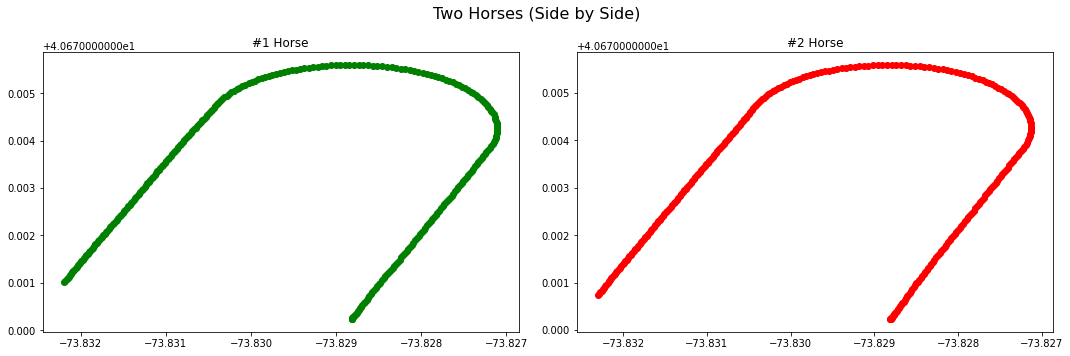

In [14]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))

fig.suptitle('Two Horses (Side by Side)', fontsize=16)

ax1.set_title('#1 Horse')
ax2.set_title('#2 Horse')

ax1.scatter(x=horse1_df['longitude'], y=horse1_df['latitude'], color='green')
ax2.scatter(x=horse2_df['longitude'], y=horse2_df['latitude'], color='red')

fig.tight_layout()

Let's overlay the two horse's path into the first turn.

Text(0.5, 1.0, 'Into the First Turn (Horse #1 and Horse #2)')

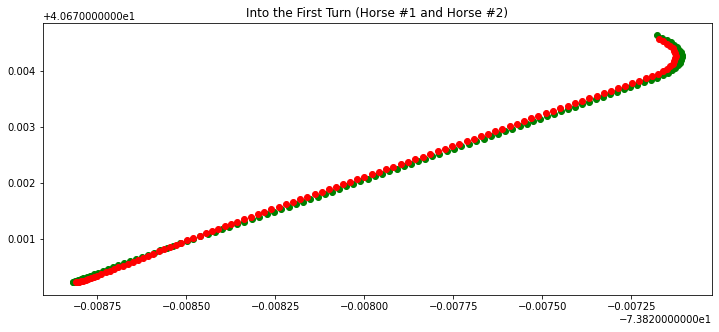

In [15]:
points = 110

plt.figure(figsize=(12,5))

plt.scatter(x=horse1_df['longitude'].head(points), y=horse1_df['latitude'].head(points), color='green')
plt.scatter(x=horse2_df['longitude'].head(points), y=horse2_df['latitude'].head(points), color='red')

plt.title('Into the First Turn (Horse #1 and Horse #2)')

In [16]:
# Sum the distance between each successive data point.
def distance(coords):
    return np.sum([geopy.distance.geodesic(coords[i], coords[i+1]).km for i in range(0, len(coords)-1)])
        
distance([(lat, long) for (lat, long) in zip(horse1_df['latitude'], horse1_df['longitude'])])

1.3163616455308316

Group the trackings by horse/race to see the tracking data point distribution.

In [17]:
grouped_df = tracking_df.groupby(
    ['track_id', 'race_date', 'race_number', 'program_number']
).agg({ 'trakus_index': 'count'}).reset_index()

grouped_df.describe()

,race_number,trakus_index
count,14915.000000,14915.000000
mean,5.494200,350.548441
std,2.826058,75.318985
min,1.000000,4.000000
25%,3.000000,294.000000
50%,6.000000,336.000000
75%,8.000000,396.000000
max,13.000000,1062.000000


Load the distances at each part of the race that was calculated in Azure.

In [18]:
consolidated_df = pd.read_csv('./data/consolidated-races.csv')
len(consolidated_df)

14915

In [19]:
consolidated_df.head(5).T

,0,1,2,3,4
track_id,AQU,AQU,AQU,AQU,AQU
race_date,2019-01-01,2019-01-01,2019-01-01,2019-01-01,2019-01-01
race_number,1,1,1,1,1
program_number,1,2,3,4,5
weight_carried,123,120,118,123,118
jockey,Dylan Davis,Junior Alvarado,Jose Lezcano,Jomar Garcia,Manuel Franco
odds,130,295,180,1280,1150
position_at_finish,2,3,4,5,1
distance_25,0.358618,0.343362,0.356291,0.353255,0.347509
distance_50,0.746769,0.730764,0.744562,0.741265,0.741464


In [20]:
consolidated_df.corr()

,race_number,weight_carried,odds,position_at_finish,distance_25,distance_50,distance_75,distance_100,distance_id,run_up_distance,purse,post_time
race_number,1.000000,-0.062257,0.079798,0.149515,0.034078,0.035799,0.043145,0.047557,0.044450,0.080193,0.260156,0.095697
weight_carried,-0.062257,1.000000,-0.131107,-0.077827,0.311567,0.327109,0.335208,0.337466,0.345645,-0.064194,0.028334,0.096708
odds,0.079798,-0.131107,1.000000,0.468030,-0.019069,-0.021013,-0.029265,-0.035949,-0.018366,0.014068,0.000795,0.024280
position_at_finish,0.149515,-0.077827,0.468030,1.000000,-0.023816,-0.028280,-0.042548,-0.062527,-0.003825,0.048854,0.020090,0.032470
distance_25,0.034078,0.311567,-0.019069,-0.023816,1.000000,0.994485,0.985025,0.965235,0.935059,0.136171,0.230750,0.135704
distance_50,0.035799,0.327109,-0.021013,-0.028280,0.994485,1.000000,0.994907,0.977979,0.946452,0.140806,0.233121,0.133089
distance_75,0.043145,0.335208,-0.029265,-0.042548,0.985025,0.994907,1.000000,0.992404,0.960285,0.169875,0.248059,0.133883
distance_100,0.047557,0.337466,-0.035949,-0.062527,0.965235,0.977979,0.992404,1.000000,0.967411,0.199401,0.259009,0.134793
distance_id,0.044450,0.345645,-0.018366,-0.003825,0.935059,0.946452,0.960285,0.967411,1.000000,0.169451,0.274999,0.133931
run_up_distance,0.080193,-0.064194,0.014068,0.048854,0.136171,0.140806,0.169875,0.199401,0.169451,1.000000,0.023495,-0.006911
